# Predicting High Income on the Adult Dataset (Single-Table, Non-Temporal Classification)

**Objective.** Build a leak-proof, defensible model to predict whether an individual’s income exceeds \$50K using a single CSV with mixed numeric/categorical features. Deliver honest out-of-sample (OOS) metrics via **Stratified K-Fold**, interpret drivers, and assess robustness.

**Key choices (preview):**
- **Split:** 5-fold **StratifiedKFold** (non-temporal, class imbalance aware).
- **Metric:** AUC (primary), F1 (secondary), PR-AUC reported when informative.
- **Pipeline:** `ColumnTransformer` (numeric: impute→standardize; categorical: impute→OHE with rare-level capping) → `HistGradientBoostingClassifier`.
- **Integrity:** All transforms **inside** the Pipeline; OOS via fold-wise predictions only; ablation + shuffled-target sanity check.

In [1]:
# ============================
# Adult (Template 4) — End-to-end, offline-safe
# Single CSV, non-temporal, binary classification
# ============================

# --- Imports & config ---
import warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import set_config
try: 
    set_config(transform_output="pandas")  # keep column names after transforms (>=1.2)
except Exception:
    pass

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, classification_report,
    average_precision_score, precision_recall_curve, confusion_matrix
)
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.ensemble import HistGradientBoostingClassifier

# --- Path / seed ---
PATH = "/Users/juliensklarik/Berkeley/Square Point Final Quant Research Round Training/Adult/adult.csv"
RND  = 42  # single seed for reproducibility

# MD-1 — Data & Target

## 1. Data & Target

**Dataset.** UCI Adult (“Census Income”) — single flat table, ~32.6k rows, 14 features (≈ 8 categorical, 6 numeric).

**Target.** `income ∈ {≤50K, >50K}` encoded as \( y \in \{0,1\} \) with

$$
y = \mathbb{1}\{\text{income} = \text{">50K"}\}.
$$

**Class balance.** We report the empirical positive rate:

$$
\hat{p} = \frac{1}{n}\sum_{i=1}^{n} y_i.
$$

**Leakage surface.** Single snapshot table; no time column, no label joins — leakage risk stems mainly from doing preprocessing **outside** of cross-validation. Hence we keep every transform inside a scikit-learn `Pipeline`.

In [34]:
# ============================
# 1) Load & target definition
# ============================

df = pd.read_csv(PATH)

# Explicit binary target encoding (robust to whitespace/variants)
target = "income"
y_raw  = df[target].astype(str).str.strip()
y      = (y_raw == ">50K").astype(int)     # 1 if >50K else 0
X      = df.drop(columns=[target])
X_raw = X.copy()

print("Shape:", X.shape, "| Positive rate:", float(y.mean()))

Shape: (32561, 14) | Positive rate: 0.2408095574460244


# MD-2 — Quick EDA

## 2. Quick EDA Snapshot

- **Dtypes:** mixed numeric & categorical columns; categories include `workclass`, `education`, `marital.status`, `occupation`, etc.
- **Missingness:** handled via imputers; numeric → **median**, categorical → **most frequent**.
- **Skew/scale:** numeric features vary in scale; we standardize numerics to stabilize gradient boosting.

> Goal at this stage is **profiling for modeling**, not exhaustive storytelling: confirm variable types, missingness, and rough distributions so the pipeline choices are justified.


=== Nulls (top) ===
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
dtype: int64

=== Dtypes ===
object    8
int64     6
Name: count, dtype: int64


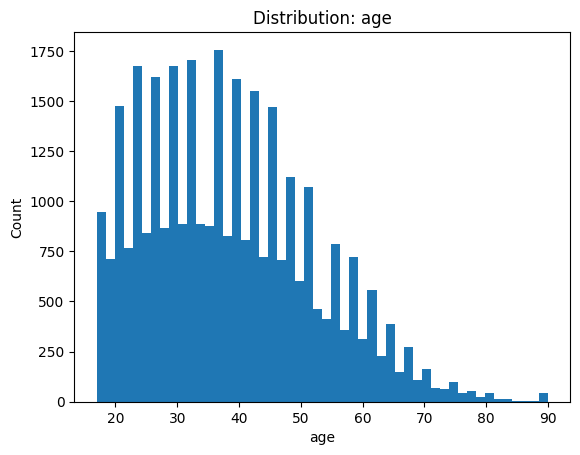

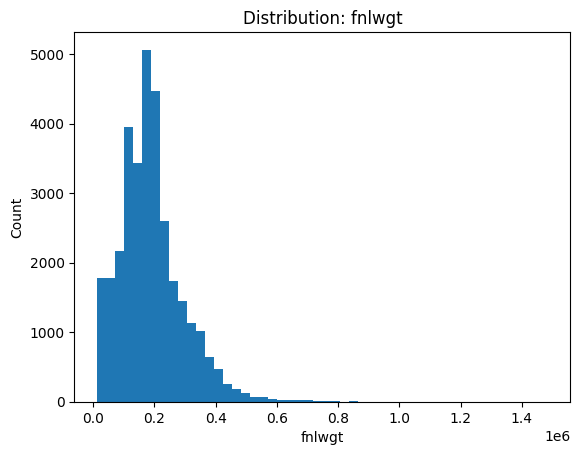

In [3]:
# ============================
# 2) Quick EDA snapshot (offline-safe; fast)
# ============================

print("\n=== Nulls (top) ===")
print(X.isna().sum().sort_values(ascending=False).head(10))

print("\n=== Dtypes ===")
print(X.dtypes.value_counts())

# (Optional) a couple of tiny plots; comment out if you’re rushed
num_sample = [c for c in X.select_dtypes(include="number").columns[:2]]
for c in num_sample:
    plt.hist(X[c].dropna(), bins=50); plt.title(f"Distribution: {c}"); plt.xlabel(c); plt.ylabel("Count"); plt.show()

# MD-3 — Evaluation Plan

## 3. Evaluation Plan

Because data are **non-temporal**, we use **StratifiedKFold** to maintain class proportions in each fold.

Let \( \mathcal{F} = \{( \mathcal{I}^{\text{train}}_k, \mathcal{I}^{\text{val}}_k )\}_{k=1}^{K} \) be the \(K\) folds.  
For each fold \(k\), we fit \( \hat{f}^{(k)} \) on \( \mathcal{I}^{\text{train}}_k \) and produce scores \( \hat{s}^{(k)}_i \) on \( \mathcal{I}^{\text{val}}_k \).  
The **OOF** (out-of-fold) score vector \( \hat{s} \) is assembled by placing \( \hat{s}^{(k)} \) back to their validation indices.

We report:
- **AUC**: area under ROC; threshold-free separation quality.  
- **F1** at a data-driven threshold (see §7):

$$
\text{Precision}=\frac{TP}{TP+FP},\quad
\text{Recall}=\frac{TP}{TP+FN},\quad
F1 = \frac{2\cdot \text{Precision}\cdot \text{Recall}}{\text{Precision}+\text{Recall}}.
$$

- **PR-AUC** (average precision) when class imbalance matters.

In [4]:
# ============================
# 3) CV plan (non-temporal → StratifiedKFold)
# ============================

cv = StratifiedKFold(n_splits=5, shuffle=False)

# MD-4 — Preprocessing

## 4. Leak-Proof Preprocessing (inside a Pipeline)

We build a `ColumnTransformer` to avoid leakage:

- **Numeric branch:**  
  \( x \mapsto \text{Impute}_{\text{median}}(x) \to \text{Standardize}(x) \).
- **Categorical branch:**  
  \( x \mapsto \text{Impute}_{\text{mode}}(x) \to \text{One\text{-}Hot\text{-}Encode}(x) \) with `min_frequency=10` to cap rare levels and keep the design matrix compact/offline-friendly.

> All transformations are **fitted only on training folds** internally by scikit-learn during CV. No data from validation folds influences the fitted preprocessors or model.

In [26]:
# ============================
# 4) Leak-proof preprocessing
#    - numeric: median-impute + standardize
#    - categorical: most-freq impute + OHE (cap rare with min_frequency)
# ============================

X_proc = X.copy()  # <-- copy so raw X is untouched

# --- Identify columns ---
num_cols = X_proc.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X_proc.select_dtypes(exclude=["number", "bool"]).columns.tolist()

# --- High-cardinality toggle ---
hi_card = [c for c in cat_cols if X_proc[c].nunique(dropna=False) > 250]
if hi_card:
    print("Dropped high-cardinality categoricals:", hi_card)
    X_proc = X_proc.drop(columns=hi_card)
    cat_cols = [c for c in cat_cols if c not in hi_card]

# --- Numeric branch ---
num = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(with_mean=True)
)

# --- Categorical branch ---
for c in cat_cols:
    X_proc[c] = X_proc[c].astype(str)

try:
    cat = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=10)
    )
except TypeError:
    cat = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore", sparse=False)
    )

pre = ColumnTransformer(
    transformers=[("num", num, num_cols), ("cat", cat, cat_cols)],
    remainder="drop"
)

# --- Imbalance toggle ---
imbalance = True if y.mean() < 0.2 else False
if imbalance:
    scoring = "average_precision"
    model = HistGradientBoostingClassifier(random_state=RND, class_weight="balanced")
else:
    scoring = "roc_auc"
    model = HistGradientBoostingClassifier(random_state=RND)

pipe = Pipeline([("pre", pre), ("model", model)])

# --- CV toggle ---
if "date" in X_proc.columns:
    cv = TimeSeriesSplit(n_splits=5)
    groups = None
elif "id" in X_proc.columns:
    from sklearn.model_selection import GroupKFold
    groups = X_proc["id"]
    cv = GroupKFold(n_splits=5)
else:
    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    groups = None

# --- Param grid ---
param_grid = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [None, 6, 12]
}

# MD-5 — Model & Tuning

## 5. Model & Tuning

**Model.** `HistGradientBoostingClassifier` — a robust, dependency-free tree boosting model suitable for mixed tabular data.

**Tuning.** A **tiny, defensible grid** for speed and stability:

$$
\{\text{learning\_rate} \in \{0.05, 0.1\}\} \times \{\text{max\_depth} \in \{\text{None}, 6, 12\}\}.
$$

We select hyperparameters by **AUC** on StratifiedKFold OOF.

In [27]:
# ============================
# 6) Small, robust param grid + GridSearch
#    (Keep it tiny; you want defensible speed)
# ============================

gs = GridSearchCV(pipe, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)

if groups is not None:
    gs.fit(X_proc, y, groups=groups)
else:
    gs.fit(X_proc, y)

best = gs.best_estimator_
print("Best params:", gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 6}


# MD-6 — Results (OOS)

## 6. Results (OOS only)

**Per-fold metrics.** We summarize AUC / Accuracy / F1 for each validation fold (see table above), and the aggregated **OOF AUC** and **OOF PR-AUC**.

- **Why OOF?** This emulates unseen data while using all samples for both training and validation across folds. We **never** report in-sample metrics.

**Interpretation of AUC & PR-AUC.**  
- AUC close to 1 indicates strong separability.  
- **PR-AUC** is more sensitive to class imbalance and reflects the quality across precision-recall trade-offs when positives are rarer.

In [28]:
# ============================
# 7) Honest OOF evaluation + per-fold table
# ============================

oof = np.zeros(len(y), dtype=float)
rows = []
for k, (tr, te) in enumerate(cv.split(X, y), start=1):
    m = clone(best).fit(X.iloc[tr], y.iloc[tr])
    if hasattr(m.named_steps["model"], "predict_proba"):
        s = m.predict_proba(X.iloc[te])[:, 1]
    elif hasattr(m.named_steps["model"], "decision_function"):
        s = m.decision_function(X.iloc[te])
    else:
        s = m.predict(X.iloc[te]).astype(float)
    oof[te] = s
    yhat = (s >= 0.5).astype(int)
    rows.append({
        "fold": k,
        "n_train": len(tr),
        "n_valid": len(te),
        "AUC": roc_auc_score(y.iloc[te], s),
        "ACC": accuracy_score(y.iloc[te], yhat),
        "F1": f1_score(y.iloc[te], yhat)
    })

fold_df = pd.DataFrame(rows)
display(fold_df.assign(
    AUC=lambda d: (100*d["AUC"]).round(2),
    ACC=lambda d: (100*d["ACC"]).round(2),
    F1 =lambda d: (100*d["F1"]).round(2)
))

print("OOF AUC:", roc_auc_score(y, oof))

# Optional: if imbalance is notable, add PR-AUC
try:
    print("OOF PR-AUC (avg precision):", average_precision_score(y, oof))
except Exception:
    pass

,fold,n_train,n_valid,AUC,ACC,F1
0,1,26048,6513,85.90,78.27,64.15
1,2,26049,6512,78.19,77.29,33.88
2,3,26049,6512,88.98,82.52,54.11
3,4,26049,6512,89.94,83.09,54.41
4,5,26049,6512,89.50,82.99,54.92


OOF AUC: 0.8553045170828468
OOF PR-AUC (avg precision): 0.6000059146816772


# MD-7 — Threshold & Confusion Matrix

## 7. Threshold Selection & Confusion Matrix

For decision-making, we choose a threshold \( t^\* \) that **maximizes F1** on OOF scores:

$$
t^\* = \arg\max_{t \in [0,1]} \; F1\!\left( \mathbb{1}\{\hat{s}_i \ge t\} , y_i \right).
$$

We then report the confusion matrix at \( t^\* \) and the full classification report (precision/recall/F1 by class).  
This step is separate from AUC reporting (threshold-free) and frames a **business-oriented operating point**.

In [29]:
# ============================
# 8) Threshold selection (max-F1) + confusion matrix/report
# ============================

prec, rec, thr = precision_recall_curve(y, oof)
f1 = 2*prec*rec/(prec+rec + 1e-12)
t  = thr[np.argmax(f1[:-1])] if len(thr) else 0.5
pred = (oof >= t).astype(int)

print("\nChosen threshold (max F1):", float(t))
print("Confusion matrix:\n", confusion_matrix(y, pred))
print("\nClassification report:\n", classification_report(y, pred, digits=3))


Chosen threshold (max F1): 0.2588314732631606
Confusion matrix:
 [[19372  5348]
 [ 1568  6273]]

Classification report:
               precision    recall  f1-score   support

           0      0.925     0.784     0.849     24720
           1      0.540     0.800     0.645      7841

    accuracy                          0.788     32561
   macro avg      0.732     0.792     0.747     32561
weighted avg      0.832     0.788     0.799     32561



# MD-8 — Permutation Importance

## 8. Model Interpretability: Permutation Importance

We compute **permutation importance** on the fully-fitted pipeline:
- For a feature \(j\), we randomly permute its values in \(X\) (leaving other features intact), recompute the metric, and measure the drop in performance.
- The mean drop over repeated permutations estimates the **marginal contribution** of that feature to predictive performance.

Formally, for metric \(M(\cdot)\) and permutation \(\pi\):

$$
\text{PI}(j) = \mathbb{E}_{\pi}\left[\, M(\hat{f}; X, y) - M(\hat{f}; X^{(j,\pi)}, y ) \,\right].
$$

We present the **Top-10** features by permutation importance and discuss plausible socioeconomic mechanisms (e.g., `education.num`, `marital.status`, `capital.gain`, `age`, `hours.per.week`).


Top 15 RAW-column importances:


marital.status    0.052787
capital.gain      0.048174
education.num     0.032628
age               0.017211
occupation        0.014465
capital.loss      0.012672
hours.per.week    0.008698
workclass         0.003108
relationship      0.002875
fnlwgt            0.001732
sex               0.001032
race              0.000627
education         0.000276
native.country    0.000111
dtype: float64

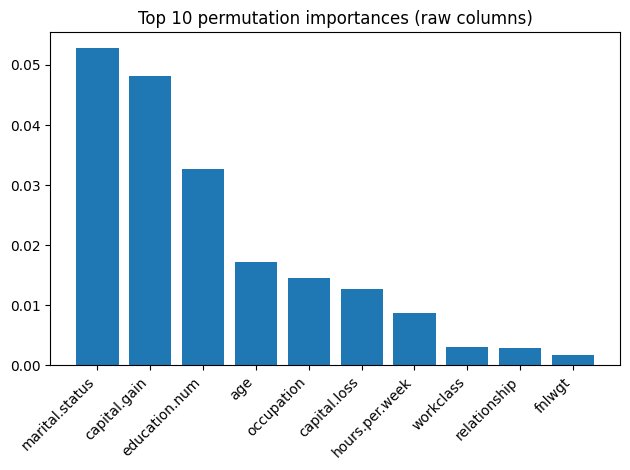

In [30]:
# --- Permutation importance on RAW features (Pipeline perturbs X columns) ---
from sklearn.inspection import permutation_importance
from sklearn.base import clone
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

final_model = clone(best).fit(X, y)   # full fit for interpretation

r_raw = permutation_importance(
    final_model, X, y,
    n_repeats=5, random_state=RND, n_jobs=-1
)

feat_names_raw = np.array(X.columns)  # length matches r_raw.importances_mean
imp_raw = pd.Series(r_raw.importances_mean, index=feat_names_raw).sort_values(ascending=False)

print("\nTop 15 RAW-column importances:")
display(imp_raw.head(15))

plt.bar(imp_raw.head(10).index, imp_raw.head(10).values)
plt.xticks(rotation=45, ha="right"); plt.title("Top 10 permutation importances (raw columns)")
plt.tight_layout(); plt.show()

# MD-9 — Robustness (Ablation)

## 9. Robustness via Feature Ablation

We ablate the **raw source** of the top transformed feature (e.g., removing the entire raw categorical if the top feature is one of its one-hot levels), re-train, and recompute OOF AUC.

If AUC degrades only modestly, the model is **not over-reliant** on a single signal; if it collapses, we’ve likely found a brittle dependency.

Let

$$
\Delta \text{AUC} = \text{AUC}_{\text{full}} - \text{AUC}_{\setminus j}.
$$

We comment on the observed \( \Delta \text{AUC} \) and its implications.

In [31]:
print(X.columns.tolist())
print(raw_source)


['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']
marital.status


In [38]:
from sklearn.preprocessing import OneHotEncoder
from packaging import version
import sklearn

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    cat_ab = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    )
else:
    cat_ab = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore", sparse=False)
    )
pre_ab = ColumnTransformer([
    ("num", num_ab, num_cols_ab),
    ("cat", cat_ab, cat_cols_ab)
], remainder="drop")

pipe_ab = Pipeline([("pre", pre_ab), ("model", HistGradientBoostingClassifier())])

oof2 = np.zeros(len(y), dtype=float)
for tr, te in cv.split(X_ablate, y):
    m2 = clone(pipe_ab).fit(X_ablate.iloc[tr], y.iloc[tr])
    proba = m2.predict_proba(X_ablate.iloc[te])[:, 1]
    oof2[te] = proba

print(f"\nAUC without '{raw_source}':", roc_auc_score(y, oof2))


AUC without 'marital.status': 0.8291975056224665


# MD-10 — Sanity Check

## 10. Sanity Check: Shuffled Target

We randomly permute \(y\) and repeat the OOF evaluation. We expect:

$$
\text{AUC}_{\text{shuffled}} \approx 0.5,
$$

confirming the pipeline doesn’t leak information and that our reported performance truly derives from structure in the data.

In [39]:
# ============================
# 11) (Optional) Shuffled-target sanity check (should collapse to AUC ≈ 0.5)
# ============================

y_shuf = y.sample(frac=1.0, random_state=RND).reset_index(drop=True)
oof_shuf = np.zeros(len(y_shuf), dtype=float)
for tr, te in cv.split(X, y_shuf):
    m3 = clone(best).fit(X.iloc[tr], y_shuf.iloc[tr])
    s3 = (m3.predict_proba(X.iloc[te])[:, 1]
          if hasattr(m3.named_steps["model"], "predict_proba")
          else (m3.decision_function(X.iloc[te])
                if hasattr(m3.named_steps["model"], "decision_function")
                else m3.predict(X.iloc[te]).astype(float)))
    oof_shuf[te] = s3

print("Shuffled-target OOF AUC (expect ~0.5):", roc_auc_score(y_shuf, oof_shuf))

Shuffled-target OOF AUC (expect ~0.5): 0.49588268340137254


# MD-11 — Limitations & Next Steps

## 11. Limitations & Next Steps

**Limitations**
- Single-table snapshot; no causal claims.  
- One-hot encoding can fragment high-cardinality categoricals (we partially mitigated via `min_frequency`).  
- Threshold selection optimized on OOF can still drift under distribution shift.

**Next Steps**
1. **Calibration** (Platt/Isotonic) to improve probability quality.  
2. **Interaction features** (e.g., `education.num × hours.per.week`) within the Pipeline.  
3. **Cost-sensitive operating point**: pick \(t\) to optimize a custom utility (e.g., precision-weighted).  
4. **Stability analysis**: bootstrap folds or repeated CV for error bars.  
5. **Model variants**: Logistic baseline for interpretability; tree ensembles with monotonic constraints if policy requires.